In [1]:
import csv
import numpy as np
import os
import operator
import pandas as pd
import pickle
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tabulate import tabulate
import colorcet as cc
import sys


### Introduction

This notebook, **py-mcr_Model_2strains**, simulates the dynamics of plasmid stability within a two-strain system consisting of plasmid-bearing ($B_p$) and plasmid-free ($B_0$) bacterial populations. The aim is to explore how ecological factors and varying levels of antibiotic selection pressure influence the persistence and loss of plasmids over time.

The notebook simulates different antibiotic concentrations to assess their impact on plasmid stability. Using a serial transfer protocol, it examines the stability of the plasmid-bearing population in both resource-limited and antibiotic-pressured environments.

Results from this notebook provide insight into the conditions under which plasmid-bearing populations can maintain stability or lose plasmids over time, forming the basis for further model extensions in subsequent notebooks.


### File structure

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#root='/content/drive/My Drive/plasmidNoise/'

root='/content/drive/MyDrive/SYNC_Projects/plasmidNoise/'

path='%s/'%root
figPath = path+'figures/'
dataPath = path+'data/Monod_parameters.csv'
runPath = path+'runs/'

sys.path.insert(0,'%scode/src/'%root)
from pOXA48_model import *


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### User-defined parameters

In [3]:
strains = ['J53_pWJ1', 'J53_pE30']
strain_names = ['J53_pWJ1', 'J53_pE30']

tot_strains = int(len(strains))
cmap_strains = cc.glasbey_light[:tot_strains]

B0 = 1e6 #Initial bacterial density
T = 24 #Duration of experimental season
S0 = 1.0 #Concentration of imiting resource
extinction_threshold=1.0 #Extinction threshold
alphas=[1e-11, 1e-12] #Antibiotic degradation rate
d=0.1 #Transfer dilution rate

A_max=65536*2 #Maximum antibiotic concentrations=[32768, 256, 1024, 32]

expe_params = {
    'B0': B0, #Initial bacterial density
    'A_max': A_max, #Maximum drug concentration
    'alphas': np.array(alphas), #Antibiotic degradation rate
    'T': T,  # Length of experiment
    'S0': S0,  # Resource concentration
    'd': d,  # Resource concentration
    'extinction_threshold': extinction_threshold,
}
verbose=False


In [4]:

model_params = import_model_params("%s"%(dataPath), expe_params)

# Experiment parameters:
type_experiment='stability'
strains_subset=[1]

num_days=52

display_model_params(model_params, strains_subset)


╒════╤══════════╤══════════╤══════════╤════════╤══════════╤═══════╤═════════════╤══════════╤═════════════╤════════════╤═════════════╕
│    │ name     │ strain   │ specie   │ type   │      PCN │   MIC │   conj_rate │      VKm │         rho │   seg_rate │       kappa │
╞════╪══════════╪══════════╪══════════╪════════╪══════════╪═══════╪═════════════╪══════════╪═════════════╪════════════╪═════════════╡
│  2 │ J53_pE30 │ J53      │ Ec       │ pE30   │   1.8173 │ 14336 │    nan      │ 5.44e-10 │ 9.63507e+08 │      0.002 │ 0.125       │
├────┼──────────┼──────────┼──────────┼────────┼──────────┼───────┼─────────────┼──────────┼─────────────┼────────────┼─────────────┤
│  4 │ J53_pE30 │ J53      │ Ec       │ WT     │ nan      │   128 │    -10.2947 │ 6.01e-10 │ 1.00818e+09 │      0.002 │ 0.000976562 │
╘════╧══════════╧══════════╧══════════╧════════╧══════════╧═══════╧═════════════╧══════════╧═════════════╧════════════╧═════════════╛


## Model


The model is based on ordinary differential equations (ODEs) that describe the growth dynamics of each subpopulation using Monod kinetics:

$$ \frac{dB_p}{dt} = \left(1 - \lambda\right) \cdot g(R; \psi_p) \cdot B_p - \kappa \cdot A \cdot B_p - \gamma \cdot B_0 \cdot B_p $$

$$ \frac{dB_0}{dt} = g(R; \psi_0) \cdot B_0 + \lambda \cdot g(R; \psi_p) \cdot B_p + \gamma \cdot B_0 \cdot B_p $$

where $g(R; \psi)$ represents the growth rate according to Monod kinetics, $\lambda$ is the segregation rate, $\kappa$ is the antibiotic susceptibility coefficient, and $\gamma$ is the conjugation rate.

In [5]:

def dB_conj(B_WT, B_TC, conj_exponent):
    if np.isnan(conj_exponent): # Below detectable limits
        conj_rate = 0
    else:
        conj_rate=10**conj_exponent
    ret = 0

    if np.size(B_TC) == 1:

        ret = 0 #conj_rate * B_WT * B_TC[0]  # Changed Bdonor to B_TC because in this case B_TC is a float
    else:
        for Bdonor in B_TC:
            ret += 0 #conj_rate * B_WT * Bdonor
    return ret


def uS(S, VKm):
    return (S * VKm) / (1 + S)

def dB_seg(B_TC, seg_rate, uSi_TC):
    # Calculate segregational loss rate, only applicable for plasmid-bearing population
    if np.isnan(seg_rate):
        seg_rate = 0
    return seg_rate * uSi_TC * B_TC

def dB_kill(A, Bs, kappa, A_max):
    kill_rate = 1 / (kappa*A_max)
    return kill_rate * A * Bs

def fMultistrain(t, y, params):
    S = y[0]
    A = y[1]
    num_strains = int(len(params['strain']) / 2)
    #B_TC = y[2:num_strains + 2]
    #B_WT = y[num_strains + 2:]


    B_TC = [max(val, 0) for val in y[2:num_strains + 2]]  # Ensure non-negativity for B_TC
    B_WT = [max(val, 0) for val in y[num_strains + 2:]]   # Ensure non-negativity for B_WT

    uStot = 0
    dB = np.zeros(2 * num_strains)

    # For plasmid-bearing (TC)
    for i in range(num_strains):

        uSi_TC = uS(S, params['VKm'].iloc[i])
        uStot += uSi_TC * B_TC[i]

        dB_TC_growth = params['rho'].iloc[i] * uSi_TC * B_TC[i]
        dB_TC_seg = params['rho'].iloc[i] * uSi_TC * B_TC[i] * params['seg_rate'].iloc[i]

        db_MIC_TC = params['kappa'].iloc[i]
        dB_TC_kill = dB_kill(A, B_TC[i], db_MIC_TC, params.attrs['A_max'])

        conj_permissiveness=params['conj_rate'].iloc[i+num_strains] #permissiveness of WT
        dB_TC_conj = dB_conj(B_WT[i], B_TC, conj_permissiveness)

        #print("dB_TC_kill:", type(dB_TC_kill), ", shape:", dB_TC_kill.shape)
        #print("dB_TC_conj:", type(dB_TC_conj), ", shape:", dB_TC_conj.shape)
        #print("dB_TC_growth:", type(dB_TC_growth), ", shape:", dB_TC_growth.shape)
        #print("dB_TC_seg:", type(dB_TC_seg), ", shape:", dB_TC_seg.shape)

        #dB[i] = dB_TC_growth.item() + dB_TC_conj.item() - dB_TC_seg.item() - dB_TC_kill.item()

        dB[i] = dB_TC_growth + dB_TC_conj - dB_TC_seg - dB_TC_kill


    # For plasmid-free (WT)
    for i in range(num_strains, 2*num_strains):

        uSi_WT = uS(S, params['VKm'].iloc[i])
        uStot += uSi_WT * B_WT[i-num_strains]

        dB_WT_growth = params['rho'].iloc[i] * uSi_WT * B_WT[i-num_strains]

        db_MIC_WT = params['kappa'].iloc[i]
        dB_WT_kill = dB_kill(A, B_WT[i-num_strains], db_MIC_WT, params.attrs['A_max'])

        uSi_TC = uS(S, params['VKm'].iloc[i-num_strains])
        dB_WT_seg= params['rho'].iloc[i - num_strains] * uSi_TC * B_TC[i - num_strains] * params['seg_rate'].iloc[i-num_strains]

        conj_permissiveness=params['conj_rate'].iloc[i] #permissiveness of WT
        dB_WT_conj = dB_conj(B_WT[i-num_strains], B_TC, conj_permissiveness)

        dB[i] = dB_WT_growth - dB_WT_conj - dB_WT_kill + dB_WT_seg
        #dB[i] = dB_WT_growth.item() + dB_WT_conj.item() - dB_WT_seg.item() - dB_WT_kill.item()


    dS =  - uStot
    dA = -A * (params.attrs['alphas'][0] * np.sum(B_TC) + params.attrs['alphas'][1] * np.sum(B_WT))



    return np.concatenate(([dS], [dA], dB))

def get_selected_strains_params(model_params, istrains):
    num_strains = int(len(model_params) / 2)

    indices_tc = model_params.loc[(model_params.index.isin(istrains)) & (model_params['type'].str.lower().str.contains('p'))].index
    indices_wt = indices_tc + num_strains

    output = pd.DataFrame()

    for key in model_params.columns:
        if key == 'type':
            output[key] = ['TC'] * len(indices_tc) + ['WT'] * len(indices_wt)
        else:
            output[key] = model_params.loc[indices_tc, key].tolist() + model_params.loc[indices_wt, key].tolist()

    output.attrs = model_params.attrs
    return output




In [6]:
def simulate_multistrain(this_params, istrains, y0):
    strains_params=get_selected_strains_params(this_params, istrains)

    num_strains = int((len(y0)-2) / 2)
    # Set initial conditions
    #S0 = this_params.attrs['S0']
    #B0 = this_params.attrs['B0']

    t_span = [0, this_params.attrs['T']]

    # Solve the ODE
    sol = solve_ivp(fMultistrain, t_span, y0, args=(strains_params,), method='Radau')


    # Extract the time points and solution vectors
    times = sol.t
    ys = sol.y

    return times, ys, strains_params

def simulateTransfers_multistrain(model_params, istrains, E, type_experiment='stability', verbose=False):
    """
    Simulate the plasmid transfer dynamics for a multi-strain community.

    This function simulates either a competition experiment where all strains start with equal biomass,
    or an invasion experiment where one strain initiates with plasmid and all others are plasmid-free.
    It then applies daily serial dilutions over a course of multiple days, as per the antibiotic concentration E provided.

    Parameters:
    model_params: xr.Dataset
        Dataset containing parameters for the model.
    istrains: list
        List of strains included in the simulation.
    E: list s
        List of daily antibiotic concentrations.
    type_experiment: str, optional
        Type of experiment to simulate: 'competition' or 'invasion'. Default is 'invasion'.
    verbose: bool, optional
        If True, print more information during simulation. Default is False.

    Returns:
    times_list: list
        List of arrays, each containing time points of a simulation for each day.
    ys_list: list
        List of arrays, each containing biomass densities of each strain at different time points for each day.
    strains_params_list: list
        List of arrays, each containing parameters of each strain for each day.
    """
    times_list = []
    ys_list = []
    strains_params_list = []
    num_strains = len(istrains)

    # Set initial conditions
    S0 = model_params.attrs['S0']
    B0 = model_params.attrs['B0']

    for day in range(len(E)):
        A = E[day]

        if day == 0:
            # Competition experiment
            if type_experiment=='stability':
                istrains_TC0 = B0 * np.ones(num_strains) / num_strains
                istrains_WT0 = B0 * np.ones(num_strains) / num_strains/100
                yi = np.concatenate(([S0], [A], istrains_TC0, istrains_WT0))

            elif type_experiment=='competition':
                yi = np.concatenate(([S0], [A], B0 * np.ones(2 * num_strains) / (num_strains * 2)))

            elif type_experiment=='invasion':  # Invasion experiment
                istrains_TC0 = np.zeros(num_strains)
                istrains_WT0 = B0 * np.ones(num_strains) / num_strains
                yi = np.concatenate(([S0], [A], istrains_TC0, istrains_WT0))
                yi[2] = B0 * 1e-3  # Only one strain initiates with plasmid at 0.1%

            # Simulation for the first day
            times, ys, strains_params = simulate_multistrain(model_params, istrains, yi)

        else:
            yi = ys[:, -1] * model_params.attrs['d']  # Serial dilution
            yi[0] = model_params.attrs['S0']  # Replenish media
            yi[1] = A  # Replenish drug

            # Simulations for subsequent days
            times, ys, strains_params = simulate_multistrain(model_params, istrains, yi)

        times_list.append(times)
        ys_list.append(ys)
        strains_params_list.append(strains_params)

    return times_list, ys_list, strains_params_list

def analyze_simulation(model_params, this_istrains, final_ys):
    """
    Analyzes the results of a simulation by computing total biomass and plasmid frequencies for combined E. coli and Klebsiella strains.

    Parameters:
    model_params: xr.Dataset
        Dataset containing model parameters.
    this_istrains: list
        List of strains included in the simulation.
    final_ys: array
        Array containing the final biomass densities of each strain for each day.

    Returns:
    Btot, freq_combined: arrays
        Arrays containing the total biomass and plasmid frequencies for combined E. coli and Klebsiella strains for each day.
    """

    B = np.array(final_ys)
    B = B[:, 2:]  # Remove the first two columns (assuming they correspond to time and resource concentration)
    num_days = B.shape[0]
    num_strains = B.shape[1] // 2

    # Initialize arrays to store total biomass and plasmid frequencies
    Btot = np.zeros(num_days)
    freq_combined = np.zeros(num_days)

    for day in range(num_days):
        for i in range(num_strains):
            Btot[day] += B[day, i + num_strains] + B[day, i]

        # Compute combined plasmid frequency
        if Btot[day] > 0:
            freq_combined[day] = (np.sum(B[day, :num_strains]) / Btot[day])
        else:
            freq_combined[day] = np.nan

    return Btot, freq_combined




In [7]:

def runEvolutionaryExperiment(type_experiment, model_params, strains_subset, As, verbose=False):
    result = {}  # Dictionary to store daily results


    # Print the strains subset
    if verbose:
      print("Strains=%s" % strains_subset)
      print_expe_params(expe_params)

    # Simulate transfers
    times_list, ys_list, strains_params_list = simulateTransfers_multistrain(model_params, strains_subset, As, type_experiment, verbose=verbose)

    # Get final points
    final_times, final_ys = get_final_points(times_list, ys_list)

    # Analyze simulation results
    Btot, freqp = analyze_simulation(model_params, strains_subset, final_ys)

    #print(Btot)

    # Collect results for this combination of strains_subset and Amax
    for iA in range(len(As)):
        result[iA] = {
            'E': As[iA],
            'Btot': Btot[iA],
            'freqp': freqp[iA],
            'ts': times_list[iA],
            'ys': ys_list[iA]
        }

    return result


In [8]:


def plot_resource_antibiotic_vs_time(result):
    # Define a list of colors for strains
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

    plt.figure(figsize=(12, 4))
    for day, day_result in enumerate(result.values()):
        # Plot resource concentration
        plt.plot(day_result['ts'] + T * day, day_result['ys'][0], '-', color='blue', label='Resource' if day == 0 else '')

        # Plot antibiotic concentration
        plt.plot(day_result['ts'] + T * day, day_result['ys'][1], '--', color='red', label='Antibiotic' if day == 0 else '')

    plt.xlabel('Time (days)', fontsize=14)
    plt.ylabel('Concentration', fontsize=14)
    plt.xticks(np.arange(0, len(result) * 24 + 1, 24*7), labels=np.arange(0, num_days + 1, 7), fontsize=12)
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.show()

def plot_Btot_vs_time(result):
    # Define a list of colors
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

    plt.figure(figsize=(12, 4))
    for day, day_result in enumerate(result.values()):
        num_strains = int(len(day_result['ys'][2:]) / 2)
        for istrain in range(num_strains):
            color_strain = colors[istrain % len(colors)]  # Loop over colors
            if day==0:
              plt.plot(day_result['ts']+T*day, day_result['ys'][2 + istrain,:], '-', color=color_strain, label='Plasmid-bearing')
              plt.plot(day_result['ts']+T*day, day_result['ys'][2 + istrain + num_strains,:], ':', color=color_strain, label='Plasmid-free')
            else:
              plt.plot(day_result['ts']+T*day, day_result['ys'][2 + istrain,:], '-', color=color_strain)
              plt.plot(day_result['ts']+T*day, day_result['ys'][2 + istrain + num_strains,:], ':', color=color_strain)

    plt.xlabel('Time (days)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    #plt.yscale('log')
    plt.xticks(np.arange(0, len(result) * 24 + 1, 24*7), labels=np.arange(0, num_days + 1, 7), fontsize=12)
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.show()


def plot_BT_vs_time(result):
    # Define a list of colors
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

    plt.figure(figsize=(12, 4))
    for istrain in range(len(result[0]['ys'][2:]) // 2):
        ODT_time = []  # Initialize lists for each strain
        ODT_strain = []
        ODTp_strain = []
        for day, day_result in enumerate(result.values()):

            if day==0:
              ODT_time.append(0)  # Append initial condition
              ODT_strain.append(day_result['ys'][2 + istrain + len(result[0]['ys'][2:]) // 2, 0])
              ODTp_strain.append(day_result['ys'][2 + istrain, 0])

            color_strain = colors[istrain % len(colors)]  # Loop over colors
            ODT_time.append(day_result['ts'][-1] + T * day)  # Append data to lists
            ODT_strain.append(day_result['ys'][2 + istrain + len(result[0]['ys'][2:]) // 2, -1])
            ODTp_strain.append(day_result['ys'][2 + istrain, -1])

        plt.plot(ODT_time, ODT_strain, ':', color=color_strain, label='Plasmid-free')
        plt.plot(ODT_time, ODTp_strain, '-', color=color_strain, label='Plasmid-bearing')

    plt.xlabel('Time (days)', fontsize=14)
    plt.ylabel('Final density', fontsize=14)
    plt.yscale('log')
    plt.xticks(np.arange(0, len(result) * 24 + 1, 24*7), labels=np.arange(0, num_days + 1, 7), fontsize=12)
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.show()



def plot_frequency_vs_time(result):
    # Define a list of colors
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

    plt.figure(figsize=(12, 4))
    freqs = []  # To store frequencies at the end of each day

    for day, day_result in enumerate(result.values()):
        num_strains = int(len(day_result['ys'][2:]) / 2)
        for istrain in range(num_strains):
            color_strain = colors[istrain % len(colors)]  # Loop over colors



            if day == 0:
                frequency0 = 100 * day_result['ys'][2 + istrain, 0] / (day_result['ys'][2 + istrain, 0] + day_result['ys'][2 + istrain + num_strains, 0])
                freqs.append(frequency0)

            # Calculate the frequency at the end of each day
            frequency = 100 * day_result['ys'][2 + istrain, -1] / (day_result['ys'][2 + istrain, -1] + day_result['ys'][2 + istrain + num_strains, -1])
            freqs.append(frequency)

    plt.xlabel('Time (days)', fontsize=14)
    plt.ylabel('Plasmid frequency (%)', fontsize=14)
    plt.xticks(np.arange(0, len(result) * 24 + 1, 24*7), labels=np.arange(0, len(result) + 1, 7), fontsize=12)
    plt.ylim([-5, 105])
    plt.yticks(fontsize=12)
    plt.grid(False)

    # Plot all frequencies together
    plt.plot(np.arange(0, len(result) * 24 +1, 24), freqs, '-o', color='b', label='All days')

    plt.show()


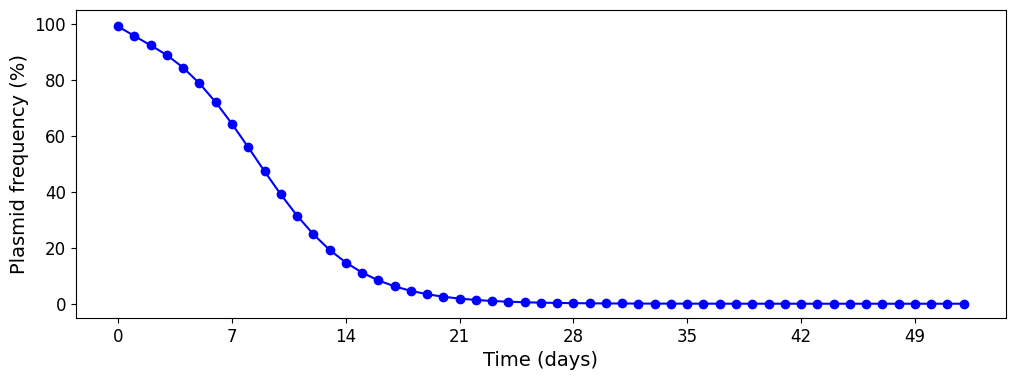

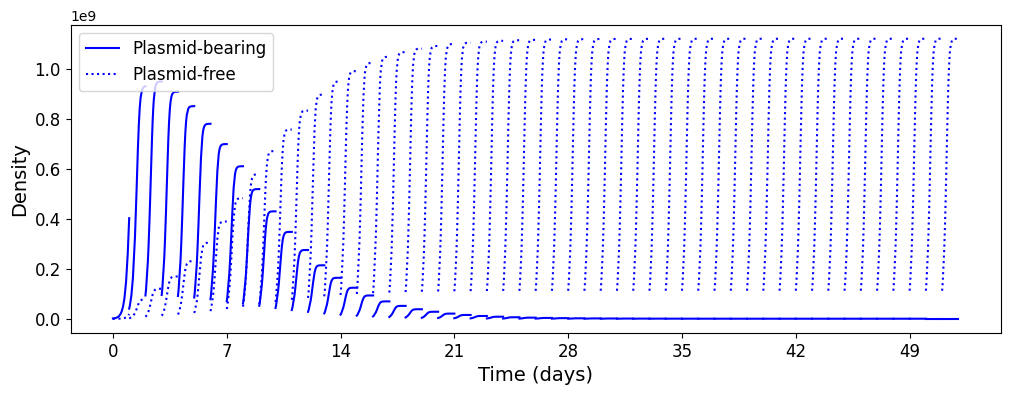

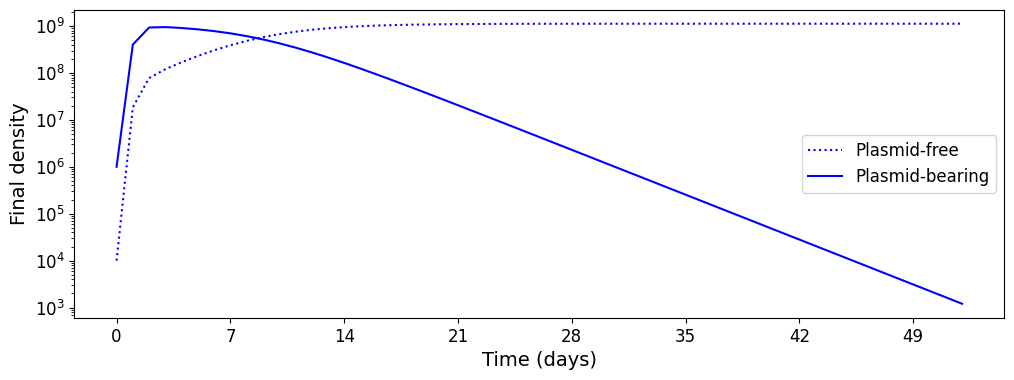

In [9]:

Amax0=0. #No colistin
As0 = Amax0*np.ones(num_days)

result0 = runEvolutionaryExperiment(type_experiment, model_params, strains_subset, As0, verbose=False)

plot_frequency_vs_time(result0)
plot_Btot_vs_time(result0)
plot_BT_vs_time(result0)
#plot_resource_antibiotic_vs_time(result0)

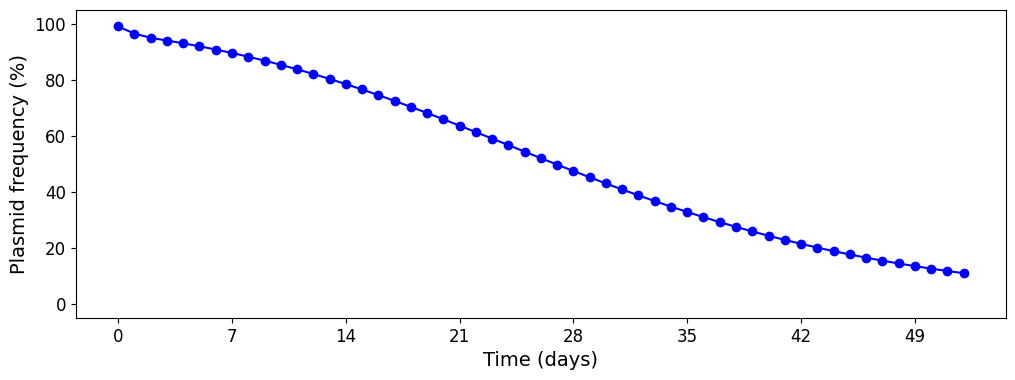

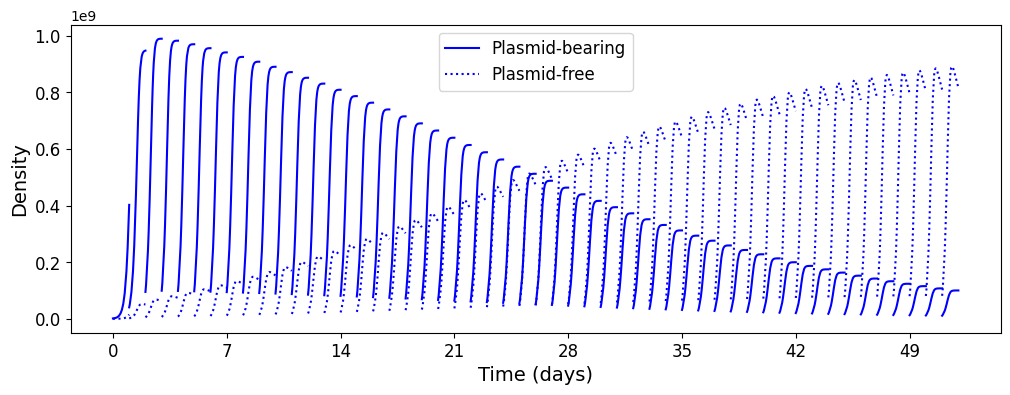

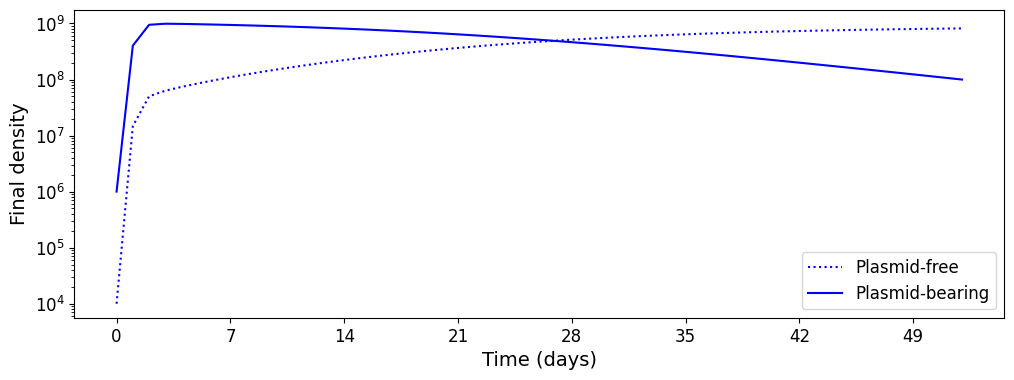

In [10]:

Amax=1.5 #Colistin
As1 = Amax*np.ones(num_days)
result1 = runEvolutionaryExperiment(type_experiment, model_params, strains_subset, As1, verbose=False)

plot_frequency_vs_time(result1)
plot_Btot_vs_time(result1)
plot_BT_vs_time(result1)
#plot_resource_antibiotic_vs_time(result1)

In [11]:
# Define the range of Amax values
Amax_values = [0.0, 0.5, 1., 1.5, 2.0]
results = []
labels = []

# Run the experiment and collect results for each Amax value
for Amax in Amax_values:
    As = Amax * np.ones(num_days)
    result = runEvolutionaryExperiment(type_experiment, model_params, strains_subset, As, verbose=True)
    results.append(result)
    if Amax==0:
      labels.append('No colistin')

    else:
      labels.append(r'%s $\mu$g/ml colistin'%Amax)


Strains=[1]
Experimental Parameters:
------------------------------------------------
	Initial bacterial density (B0): 1000000.0
	Maximum drug concentration (A_max): 131072
	Antibiotic degradation rates (alphas): [1.e-11 1.e-12]
	Length of experiment (T): 24
	Initial resource concentration (S0): 1.0
	Resource decay rate (d): 0.1
	Extinction threshold: 1.0
------------------------------------------------
Strains=[1]
Experimental Parameters:
------------------------------------------------
	Initial bacterial density (B0): 1000000.0
	Maximum drug concentration (A_max): 131072
	Antibiotic degradation rates (alphas): [1.e-11 1.e-12]
	Length of experiment (T): 24
	Initial resource concentration (S0): 1.0
	Resource decay rate (d): 0.1
	Extinction threshold: 1.0
------------------------------------------------
Strains=[1]
Experimental Parameters:
------------------------------------------------
	Initial bacterial density (B0): 1000000.0
	Maximum drug concentration (A_max): 131072
	Antibiotic d

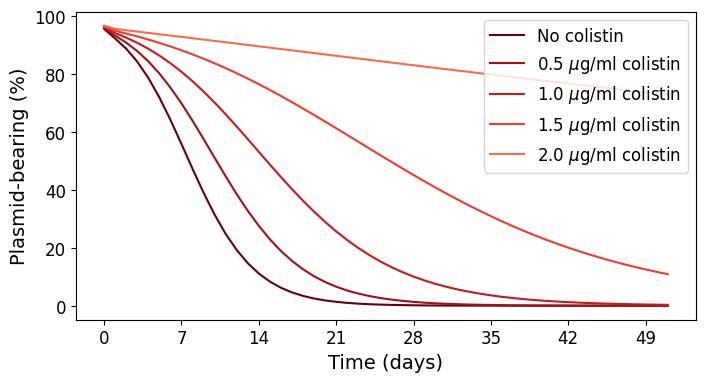

In [12]:

def plot_frequencies_vs_time(results, labels, Amax_values):
    plt.figure(figsize=(8, 4))

    # Define a colormap ranging from light red to dark red
    cmap = plt.get_cmap('Reds_r')

    for idx, result in enumerate(results):
        freqs_result = []
        for day, day_result in enumerate(result.values()):
            num_strains = int(len(day_result['ys'][2:]) / 2)
            for istrain in range(num_strains):
                freqs_result.append(100 * day_result['ys'][2 + istrain, -1] /
                                     (day_result['ys'][2 + istrain, -1] + day_result['ys'][2 + istrain + num_strains, -1]))

        # Calculate the color based on Amax value
        color = cmap(Amax_values[idx] / max(Amax_values) / 2)

        plt.plot(np.arange(0, len(result) * 24 , 24), freqs_result, '-', color=color, label=labels[idx])

    plt.xticks(np.arange(0, len(results[0]) * 24 + 1, 24*7), labels=np.arange(0, len(results[0]) + 1, 7), fontsize=12)
    plt.yticks(np.arange(0, 101, 20), fontsize=12)
    plt.xlabel('Time (days)', fontsize=14)
    plt.ylabel('Plasmid-bearing (%)', fontsize=14)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(False)

    plt.show()

# Plot the frequencies versus time for all Amax values
plot_frequencies_vs_time(results, labels, Amax_values)

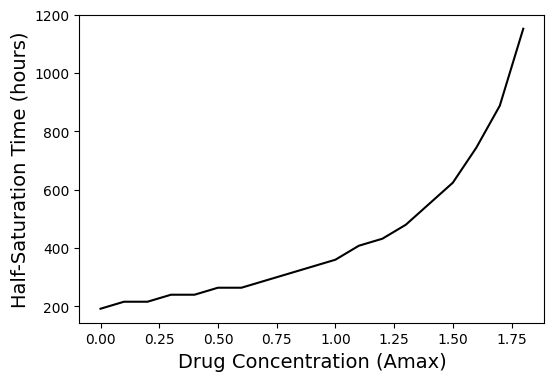

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def compute_half_saturation(results, Amax_values):
    half_saturation_times = []

    for idx, result in enumerate(results):
        initial_freq = 100  # Start with the plasmid-bearing population at 100%
        half_freq = initial_freq / 2  # Define the half-saturation point
        half_saturation_time = None

        for day, day_result in enumerate(result.values()):
            num_strains = int(len(day_result['ys'][2:]) / 2)
            # Compute the plasmid-bearing frequency
            freqs_result = [
                100 * day_result['ys'][2 + istrain, -1] /
                (day_result['ys'][2 + istrain, -1] + day_result['ys'][2 + istrain + num_strains, -1])
                for istrain in range(num_strains)
            ]

            # If any frequency falls below half the initial frequency, record the time
            if np.any(np.array(freqs_result) <= half_freq):
                half_saturation_time = day * 24  # Convert days to hours
                break

        # Append the result (if half-saturation was not reached, set to None)
        half_saturation_times.append(half_saturation_time if half_saturation_time is not None else np.nan)

    return half_saturation_times

def plot_half_saturation(Amax_values, half_saturation_times):
    plt.figure(figsize=(6, 4))
    plt.plot(Amax_values, half_saturation_times, '-', color='black')
    plt.xlabel('Drug Concentration (Amax)', fontsize=14)
    plt.ylabel('Half-Saturation Time (hours)', fontsize=14)
    plt.grid(False)
    plt.show()


expe_params['T'] = 500

# Define the range of Amax values
Amax_values = [round(x, 2) for x in np.arange(0.0, 5.1, 0.1)]

results = []
labels = []

# Run the experiment and collect results for each Amax value
for Amax in Amax_values:
    As = Amax * np.ones(num_days)
    result = runEvolutionaryExperiment(type_experiment, model_params, strains_subset, As)
    results.append(result)
    if Amax==0:
      labels.append('No colistin')

    else:
      labels.append(r'%s $\mu$g/ml colistin'%Amax)


# Compute the half-saturation times
half_saturation_times = compute_half_saturation(results, Amax_values)

# Plot the half-saturation times versus drug concentrations
plot_half_saturation(Amax_values, half_saturation_times)


In [14]:
def extract_terminal_conditions(result):
    """
    Extract the terminal conditions from the last day of the simulation.
    Parameters
    ----------
    result : dict
        The result dictionary from runEvolutionaryExperiment function.
    Returns
    -------
    terminal_conditions : array
        Array containing the resource, antibiotic, and strain densities.
    """
    # Get the last day index
    last_day = len(result) - 1
    terminal_ys = result[last_day]['ys']

    # Extract the resource, antibiotic concentration, and strains' densities
    resource = terminal_ys[0, -1]  # Last value of resource concentration
    antibiotic = terminal_ys[1, -1]  # Last value of antibiotic concentration
    Bp_densities = terminal_ys[2:2+len(strains_subset), -1]  # Plasmid-bearing strains
    B0_densities = terminal_ys[2+len(strains_subset):, -1]  # Plasmid-free strains

    # Combine all into a single array
    terminal_conditions = np.concatenate(([resource], [antibiotic], Bp_densities, B0_densities))
    return terminal_conditions


In [15]:
def runSingleDayExperiment(model_params, strains_subset, terminal_conditions, Amax):
    """
    Run a single-day experiment using the terminal conditions provided.
    Parameters
    ----------
    model_params : dict
        Dictionary of model parameters.
    strains_subset : list
        List of strains included in the simulation.
    terminal_conditions : array
        Initial state values [S, A, Bp_1, B0_1, Bp_2, B0_2, ...].
    Amax : float
        Antibiotic concentration for the 1-day experiment.
    Returns
    -------
    times, ys : arrays
        Arrays containing time points and state values for the 1-day experiment.
    """
    # Update the antibiotic concentration in the initial conditions
    terminal_conditions[1] = Amax  # Set the antibiotic concentration

    # Run the simulation for one day using the terminal conditions
    times, ys, strains_params = simulate_multistrain(model_params, strains_subset, terminal_conditions)

    return times, ys


In [16]:


# Initialize dictionaries to store terminal densities for Bp and B0 separately
terminal_densities_Bp = {strain: [] for strain in strains_subset}
terminal_densities_B0 = {strain: [] for strain in strains_subset}


for Amax0 in Amax_values:
    # Set up the initial conditions for the multi-day experiment
    num_days = 53  # Duration of the initial experiment
    As0 = Amax0 * np.ones(num_days)  # Array of antibiotic concentrations for each day

    # Run the initial multi-day experiment
    result0 = runEvolutionaryExperiment(type_experiment, model_params, strains_subset, As0, verbose=False)

    # Extract terminal conditions from the last day of the initial experiment
    terminal_conditions = extract_terminal_conditions(result0)

    # Run the single-day experiment using the terminal conditions as the initial state
    times_1day, ys_1day = runSingleDayExperiment(model_params, strains_subset, terminal_conditions, Amax0)

    # Extract the terminal densities for each Bp and B0
    for i, strain in enumerate(strains_subset):
        Bp_terminal_density = ys_1day[2 + i, -1]  # Get the last value (final density) for Bp of each strain
        B0_terminal_density = ys_1day[2 + len(strains_subset) + i, -1]  # Get the last value for B0 of each strain

        # Store the terminal densities
        terminal_densities_Bp[strain].append(Bp_terminal_density)
        terminal_densities_B0[strain].append(B0_terminal_density)


<ipython-input-17-b07b536933e4>:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(Amax_values, terminal_densities_B0[strain], '-', label=f'B0', linestyle='--')


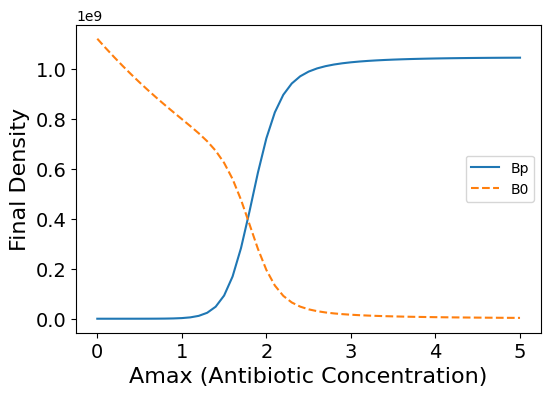

In [17]:
# Plot Amax0 vs terminal densities for each strain (Bp and B0 separately)
plt.figure(figsize=(6, 4))

for i, strain in enumerate(strains_subset):
    plt.plot(Amax_values, terminal_densities_Bp[strain], '-', label=f'Bp')
    plt.plot(Amax_values, terminal_densities_B0[strain], '-', label=f'B0', linestyle='--')

plt.xlabel('Amax (Antibiotic Concentration)', fontsize=16)
plt.ylabel('Final Density', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.grid(False)
plt.show()


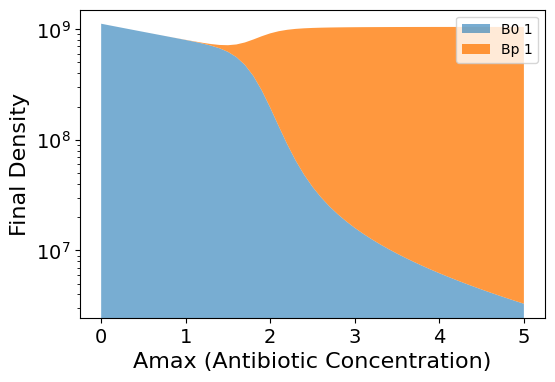

In [18]:
# Plot Amax0 vs terminal densities for each strain as stacked areas
plt.figure(figsize=(6, 4))

for i, strain in enumerate(strains_subset):
    Bp_values = np.array(terminal_densities_Bp[strain])
    B0_values = np.array(terminal_densities_B0[strain])

    # Calculate cumulative values for stacking
    B_total = Bp_values + B0_values

    # Fill the area for B0 first
    plt.fill_between(Amax_values, 0, B0_values, label=f'B0 {strain}', alpha=0.6)

    # Fill the area for Bp on top of B0
    plt.fill_between(Amax_values, B0_values, B_total, label=f'Bp {strain}', alpha=0.8)

plt.xlabel('Amax (Antibiotic Concentration)', fontsize=16)
plt.ylabel('Final Density', fontsize=16)
plt.yscale('log')  # Use logarithmic scale for better visualization if needed
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.grid(False)
plt.show()
